In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import (mean, std)
from sklearn.datasets import make_classification
from sklearn.model_selection import (cross_val_score, RepeatedStratifiedKFold)
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import (StackingClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier, 
                             AdaBoostClassifier)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from numpy import where
from sklearn.tree import DecisionTreeClassifier
import xgboost as xgb
%matplotlib inline

In [2]:
test = pd.read_csv('test_set_features.csv')
test['label'] = 'test'
train = pd.read_csv('training_set_features.csv')
train['label'] = 'train'
labels = pd.read_csv('training_set_labels.csv')
h1n1 = labels['h1n1_vaccine']
seasonal = labels['seasonal_vaccine']
combine = pd.concat([train, test], axis = 0)
ID = test['respondent_id']
combine = combine.drop(['respondent_id'], axis = 1)
full_train = pd.concat([labels, train], axis = 1)

In [3]:
combine_cols = combine.columns
labels_cols = labels.columns

In [4]:
#check column names
print(combine_cols)
print(labels_cols)

Index(['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds',
       'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'label'],
      dtype='object')
Index(['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], dtype='object')


In [5]:
#check the shape of the dataframes
print(train.shape)
print(test.shape)
print(labels.shape)
print(combine.shape)

(26707, 37)
(26708, 37)
(26707, 3)
(53415, 36)


In [6]:
#look at the response variables
labels.describe()

,respondent_id,h1n1_vaccine,seasonal_vaccine
count,26707.000000,26707.000000,26707.000000
mean,13353.000000,0.212454,0.465608
std,7709.791156,0.409052,0.498825
min,0.000000,0.000000,0.000000
25%,6676.500000,0.000000,0.000000
50%,13353.000000,0.000000,0.000000
75%,20029.500000,0.000000,1.000000
max,26706.000000,1.000000,1.000000


In [7]:
#26707 total rows
#21.2% got h1n1_vaccine
#46.6% got seasonal vaccine

In [78]:
combine.describe()

,h1n1_concern,h1n1_knowledge,behavioral_antiviral_meds,behavioral_avoidance,behavioral_face_mask,behavioral_wash_hands,behavioral_large_gatherings,behavioral_outside_home,behavioral_touch_face,doctor_recc_h1n1,...,label,msa,city,race_and_sex,family_size,total_behaviors,total_reccs,pro_vaxx,works,Cluster
count,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.00000,53415.000000,53415.000000,53415.000000,...,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000,53415.000000
mean,1.622072,1.263110,0.049106,0.729851,0.069082,0.826116,0.35402,0.336235,0.682037,0.209005,...,0.499991,0.265375,0.824094,5.547973,1.425761,3.046448,0.521876,9.492596,7.874848,3.052158
std,0.905293,0.615757,0.216091,0.444041,0.253595,0.379013,0.47822,0.472425,0.465689,0.406602,...,0.500005,0.441537,0.822025,1.919997,1.299739,1.598396,0.779557,3.788638,1.778187,1.815500
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2.000000,0.000000
25%,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,6.000000,0.000000,2.000000,0.000000,7.000000,7.000000,1.000000
50%,2.000000,1.000000,0.000000,1.000000,0.000000,1.000000,0.00000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,6.000000,1.000000,3.000000,0.000000,9.000000,8.000000,4.000000
75%,2.000000,2.000000,0.000000,1.000000,0.000000,1.000000,1.00000,1.000000,1.000000,0.000000,...,1.000000,1.000000,2.000000,7.000000,2.000000,4.000000,1.000000,12.000000,9.000000,5.000000
max,3.000000,2.000000,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,...,1.000000,1.000000,2.000000,7.000000,6.000000,7.000000,2.000000,20.000000,10.000000,5.000000


In [9]:
combine.dtypes

h1n1_concern                   float64
h1n1_knowledge                 float64
behavioral_antiviral_meds      float64
behavioral_avoidance           float64
behavioral_face_mask           float64
behavioral_wash_hands          float64
behavioral_large_gatherings    float64
behavioral_outside_home        float64
behavioral_touch_face          float64
doctor_recc_h1n1               float64
doctor_recc_seasonal           float64
chronic_med_condition          float64
child_under_6_months           float64
health_worker                  float64
health_insurance               float64
opinion_h1n1_vacc_effective    float64
opinion_h1n1_risk              float64
opinion_h1n1_sick_from_vacc    float64
opinion_seas_vacc_effective    float64
opinion_seas_risk              float64
opinion_seas_sick_from_vacc    float64
age_group                       object
education                       object
race                            object
sex                             object
income_poverty           

In [10]:
all_data_na = (combine.isnull().sum()/len(combine))
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:40]
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data.head(40)

,Missing Ratio
employment_occupation,0.503529
employment_industry,0.498081
health_insurance,0.458710
income_poverty,0.166994
doctor_recc_seasonal,0.080876
doctor_recc_h1n1,0.080876
rent_or_own,0.076346
employment_status,0.054928
marital_status,0.053356
education,0.052682


In [11]:
#looks like employment occupation and employment industry is code for not in work force where blank.
combine['employment_industry'] = combine['employment_industry'].fillna('abcde')
combine['employment_occupation'] = combine['employment_occupation'].fillna('fghij')

In [12]:
#split columns
combine[["msa", "city"]] = (  # Create two new features
    combine["census_msa"]           # from the Policy feature
    .str                         # through the string accessor
    .split(",", expand=True)     # by splitting on " "
                                 # and expanding the result into separate columns
)

In [13]:
combine['race_and_sex'] = combine['race'] + "_" + combine['sex']

In [14]:
label_enc = combine.select_dtypes(include = 'object').columns
print(label_enc)


Index(['age_group', 'education', 'race', 'sex', 'income_poverty',
       'marital_status', 'rent_or_own', 'employment_status', 'hhs_geo_region',
       'census_msa', 'employment_industry', 'employment_occupation', 'label',
       'msa', 'city', 'race_and_sex'],
      dtype='object')


In [15]:
# process columns, apply LabelEncoder to categorical features
from sklearn.preprocessing import LabelEncoder
for c in label_enc:
    lbl = LabelEncoder() 
    lbl.fit(list(combine[c].values)) 
    combine[c] = lbl.transform(list(combine[c].values))

# shape        
print('Shape all_data: {}'.format(combine.shape))

Shape all_data: (53415, 39)


In [16]:
all_data_na = (combine.isnull().sum()/len(combine))
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:40]
missing_data = pd.DataFrame({'Missing Ratio':all_data_na})
missing_data_reverse = missing_data.sort_values(by = ['Missing Ratio'], ascending = True)

Text(0.5, 1.0, 'Percent missing data by feature')

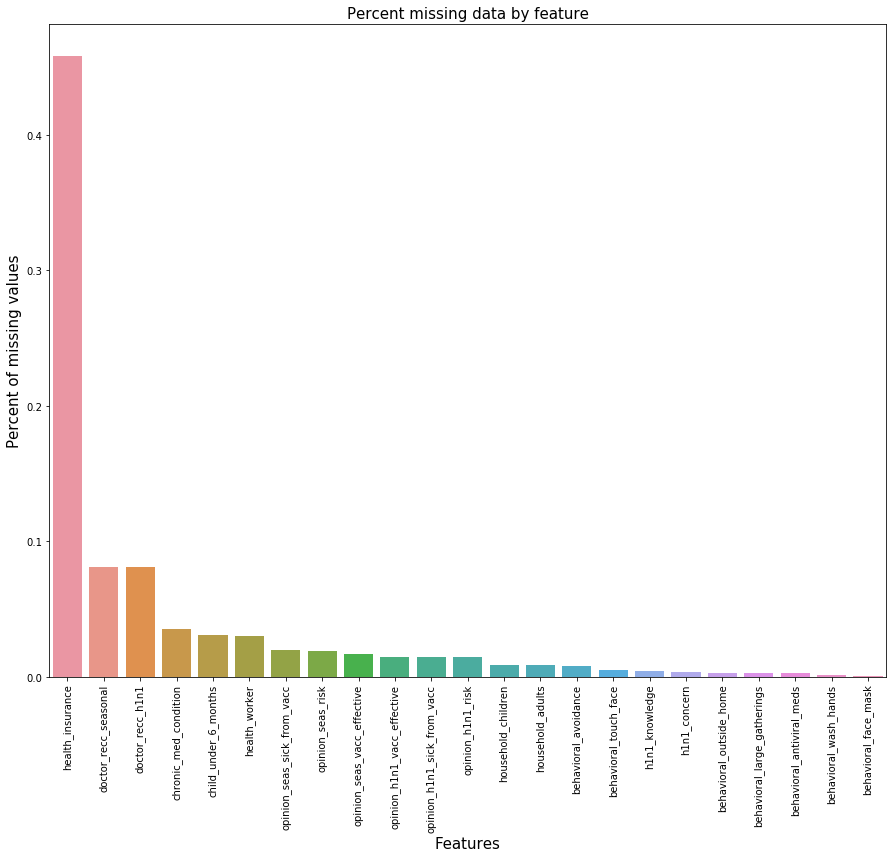

In [17]:
fig, ax = plt.subplots(figsize = (15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [18]:
#anything with under 2% missing, just input the mode
cols = ('opinion_seas_sick_from_vacc', 'opinion_seas_risk' , 'opinion_seas_vacc_effective',
        'opinion_h1n1_vacc_effective','opinion_h1n1_sick_from_vacc', 'opinion_h1n1_risk', 'household_children',
        'household_adults', 'behavioral_avoidance', 'behavioral_touch_face', 'h1n1_knowledge', 'h1n1_concern',
        'behavioral_outside_home', 'behavioral_large_gatherings', 'behavioral_antiviral_meds', 'behavioral_wash_hands',
        'behavioral_face_mask')

for c in cols:
    combine[c] = combine[c].fillna(combine[c].mode()[0])
    

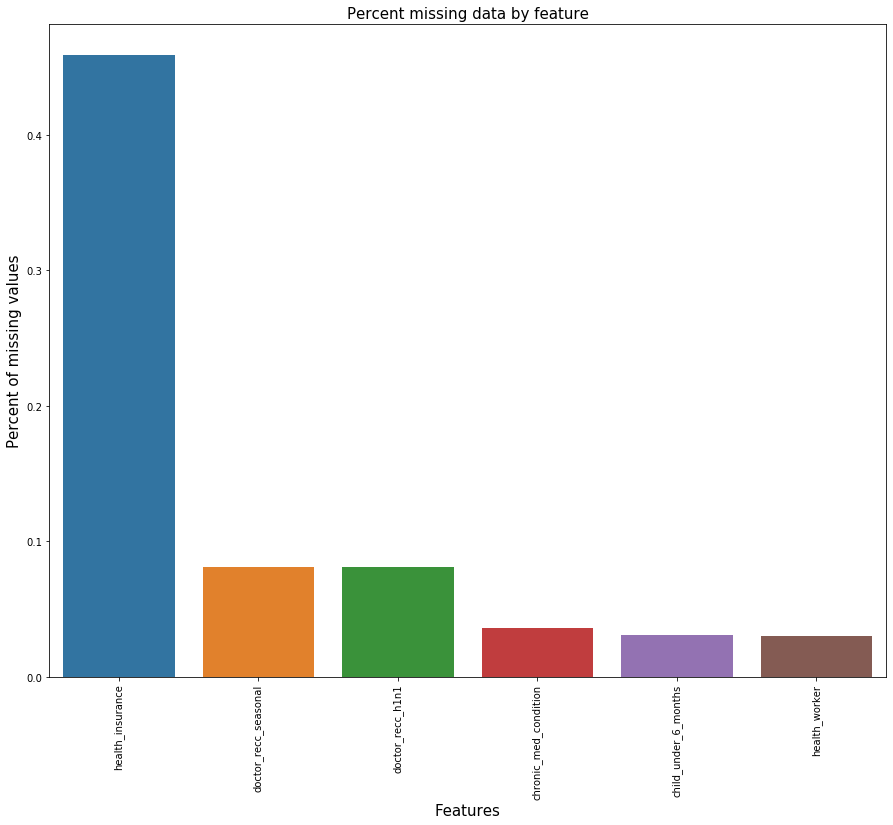

In [19]:
all_data_na = (combine.isnull().sum()/len(combine))
all_data_na = all_data_na.drop(all_data_na[all_data_na == 0].index).sort_values(ascending=False)[:40]

fig, ax = plt.subplots(figsize = (15,12))
plt.xticks(rotation='90')
sns.barplot(x=all_data_na.index, y=all_data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
cols = list(all_data_na.index)

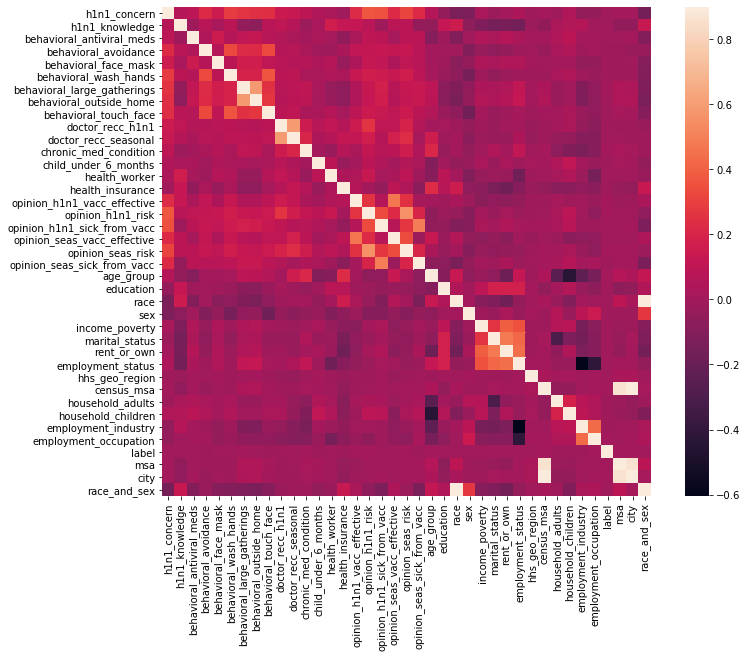

In [20]:
corrmat = combine.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

In [21]:
before = []
for c in cols:
    w = len(combine[c][combine[c]==1])
    wo = len(combine[c][combine[c]==0])
    pct_w = w / (w + wo)
    before.append(pct_w)
    print('percentage with', c, pct_w)

percentage with health_insurance 0.8838238854494518
percentage with doctor_recc_seasonal 0.33164273347591405
percentage with doctor_recc_h1n1 0.22148894999490784
percentage with chronic_med_condition 0.28214784904488277
percentage with child_under_6_months 0.08445019504847244
percentage with health_worker 0.11170931264713828


In [25]:
#build model to fill values
# Oversample and plot imbalanced dataset with SMOTE
roc = []

for index, value in enumerate(cols):
    
    a = cols[index] #sets variable to index
    cols.pop(index) #removes variable from index for next round
    X = combine.drop(columns = cols) #drops all cols that still have NAs to build model
    W = X[X[a].notnull()] # creates df with current index but drops all the NAs
    y = W[a] #makes the target the index
    X = X.drop([a], axis = 1) #drops target from test df
    W = W.drop([a], axis = 1) #drops target from training df
    
    oversample = SMOTE()
    W, y = oversample.fit_resample(W,y)
    
    #model = GradientBoostingClassifier()
    model = GradientBoostingClassifier()
    # evaluate pipeline
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, W, y, scoring='roc_auc', cv=cv, n_jobs=-1)
    print('mean roc', a, mean(scores))
    #fit model
    model.fit(W,y)
    
    #make predictions
    combine['preds'] = model.predict(X)
    combine[a] = np.where(combine[a].isnull(), 
                                           combine['preds'], combine[a])
    combine = combine.drop(['preds'], axis = 1)

mean roc chronic_med_condition 0.8852634940301113


In [26]:
combine.isnull().sum().any()

False

In [ ]:
#all NAs are gone

In [ ]:
#create baseline model with logistic regression
train = combine[combine['label'] == 1]
test = combine[combine['label'] == 0]
train = train_new.drop(['label'], axis = 1)
test = test_new.drop(['label'], axis = 1)

In [ ]:
# compare ensemble to each baseline classifier

  
# get a stacking ensemble of models
def get_stacking():
    # define the base models
    level0 = list()
    level0.append(('lr', LogisticRegression()))
    level0.append(('rf', RandomForestClassifier()))
    level0.append(('boost', GradientBoostingClassifier()))
    level0.append(('et', ExtraTreesClassifier()))
    level0.append(('ada', AdaBoostClassifier()))
    # define meta learner model
    level1 = LogisticRegression()
    # define the stacking ensemble
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model
 
# get a list of models to evaluate
def get_models():
    models = dict()
    models['lr'] = LogisticRegression()
    models['rf'] = RandomForestClassifier()
    models['boost'] = GradientBoostingClassifier()
    models['et'] = ExtraTreesClassifier()
    models['ada'] = AdaBoostClassifier()
    models['stacking'] = get_stacking()
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1, error_score='raise')
    return scores

#set data
X,y = (train, seasonal)
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
    scores = evaluate_model(model, X, y)
    results.append(scores)
    names.append(name)
    print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
plt.boxplot(results, labels=names, showmeans=True)
plt.show()

#set data
X = train
y = seasonal
#y = h1n1

# define the base models
level0 = list()
level0.append(('lr', LogisticRegression(max_iter = 1000)))
level0.append(('rf', RandomForestClassifier()))
level0.append(('boost', GradientBoostingClassifier()))
#Best: 0.822331 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.5}
level0.append(('et', ExtraTreesClassifier()))
level0.append(('ada', AdaBoostClassifier()))
# define meta learner model
level1 = LogisticRegression()
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X, y)
# make a prediction for one example
yhat = model.predict_proba(test)

y_pred_h1n1_final = pd.DataFrame(yhat, columns = ['first_class', 'second_class'])

y_pred_seasonal_final = pd.DataFrame(yhat, columns = ['first_class', 'second_class'])

response = pd.concat([ID, y_pred_h1n1_final['second_class'],y_pred_seasonal_final['second_class']], axis = 1)
response.columns = ['respondent_id','h1n1_vaccine', 'seasonal_vaccine']
response.to_csv('predictions.csv', index=False)

#.8408
#289 out of 1936. top 15%

train = train.astype(int)
print(train.dtypes)

#mutual information
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = train.dtypes == int
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(train, seasonal, discrete_features)
mi_scores2 = make_mi_scores(train, h1n1, discrete_features)
print(mi_scores[::3])  # show seasonal scores
print(mi_scores[::3])  #show h1n1 scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores - Seasonal Vaccine")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores - H1N1 Vaccine")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores2)

mi_scores[-9:]

mi_scores2[-9:]

In [ ]:
#will keep all columns. There are some bad ones. But common sense tells me some of these columns matter. and the DF is not
#all that wide to start with. 35 total columns.

In [ ]:
#engineer new columns

In [40]:
combine['family_size'] = combine['household_adults'] + combine['household_children']
combine['total_behaviors'] = combine['behavioral_antiviral_meds'] + combine['behavioral_avoidance'] + combine['behavioral_face_mask'] + combine['behavioral_wash_hands'] + combine['behavioral_large_gatherings'] + combine['behavioral_outside_home'] + combine['behavioral_touch_face']
combine['total_reccs'] = combine['doctor_recc_h1n1'] + combine['doctor_recc_seasonal']
combine['pro_vaxx'] =  combine['opinion_h1n1_risk'] + combine['opinion_h1n1_sick_from_vacc'] + combine['opinion_seas_risk'] + combine['opinion_seas_sick_from_vacc']
combine['works'] = combine['opinion_h1n1_vacc_effective'] + combine['opinion_seas_vacc_effective']


In [30]:
# Create cluster feature
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=6)
combine['Cluster'] = kmeans.fit_predict(combine)
combine['Cluster'] = combine['Cluster'].astype("category")

In [41]:
combine = combine.apply(pd.to_numeric)
combine.shape

(53415, 45)

In [42]:
#create baseline model with logistic regression
train_new = combine[combine['label'] == 1]
test_new = combine[combine['label'] == 0]
train_new = train_new.drop(['label'], axis = 1)
test_new = test_new.drop(['label'], axis = 1)

In [ ]:
"""
#use grid search to find best parameters


from sklearn.model_selection import GridSearchCV
# define the model with default hyperparameters
#model = GradientBoostingClassifier()
#model = AdaBoostClassifier()
#model = RandomForestClassifier()
#model = ExtraTreesClassifier()
model = LogisticRegression()
X, y = train_new, h1n1
# define the grid of values to search
grid = dict()

""""
grid['n_estimators'] = [10, 50, 100]
grid['learning_rate'] = [0.0001, 0.001, 0.01]
grid['subsample'] = [0.5, 0.7, 0.9]
grid['max_depth'] = [3, 7, 9]
"""
"""
grid['n_estimators'] = [10, 50, 100, 500]
grid['learning_rate'] = [0.0001, 0.001, 0.01, 0.1, 1.0]
"""
"""
grid['n_estimators'] = [50, 150, 250]
grid['max_features'] = [0.25, 0.5, 0.75, 1.0]
grid['min_samples_split'] = [2, 4, 6]
"""
"""
grid['criterion'] = ['gini', 'entropy']
grid['max_depth'] = [2, 4, 5, 6, 7, 9, 10, 15, 20]
"""
grid['C'] = [0.001, 0.01, 0.1, 1, 10, 100, 1000]
grid['penalty'] = ['l1','l2']

# define the evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define the grid search procedure

grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy')
# execute the grid search
grid_result = grid_search.fit(X, y)
# summarize the best score and configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# summarize all scores that were evaluated
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

#GradientBoost Best: 0.822331 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.5} for h1n1 and seasonal
#AdaBoost Best: 0.782005 using {'learning_rate': 1.0, 'n_estimators': 500} for seasonal
#AdaBoost Best: 0.833440 using {'learning_rate': 1.0, 'n_estimators': 100} for h1n1
#RandomForest Best: 0.778535 using {'max_features': 0.25, 'min_samples_split': 6, 'n_estimators': 250} for seasonal, h1n1
#ExtraTreesClassifier Best: 0.776314 using {'criterion': 'gini', 'max_depth': 15} seasonal
#ExtraTreesClassifier Best: 0.833465 using {'entropy': 'gini', 'max_depth': 15} h1n1
#LogisticRegression Best: 0.774591 using {'C': 0.01, 'penalty': 'l2'} seasonal
#LogisticRegression Best: 0.832815 using {'C': 1, 'penalty': 'l2'} h1n1
"""

In [43]:
#mutual information
# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = train_new.dtypes == int
from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(train_new, seasonal, discrete_features)
mi_scores2 = make_mi_scores(train_new, h1n1, discrete_features)
print(mi_scores[::3])  # show seasonal scores
print(mi_scores[::3])  #show h1n1 scores

opinion_seas_vacc_effective    0.077528
works                          0.061730
employment_occupation          0.023580
pro_vaxx                       0.020727
race_and_sex                   0.015004
health_insurance               0.013193
h1n1_concern                   0.008983
race                           0.008104
chronic_med_condition          0.006883
h1n1_knowledge                 0.005616
behavioral_wash_hands          0.005235
marital_status                 0.002749
city                           0.000000
opinion_h1n1_sick_from_vacc    0.000000
census_msa                     0.000000
Name: MI Scores, dtype: float64
opinion_seas_vacc_effective    0.077528
works                          0.061730
employment_occupation          0.023580
pro_vaxx                       0.020727
race_and_sex                   0.015004
health_insurance               0.013193
h1n1_concern                   0.008983
race                           0.008104
chronic_med_condition          0.006883
h1n1_kno

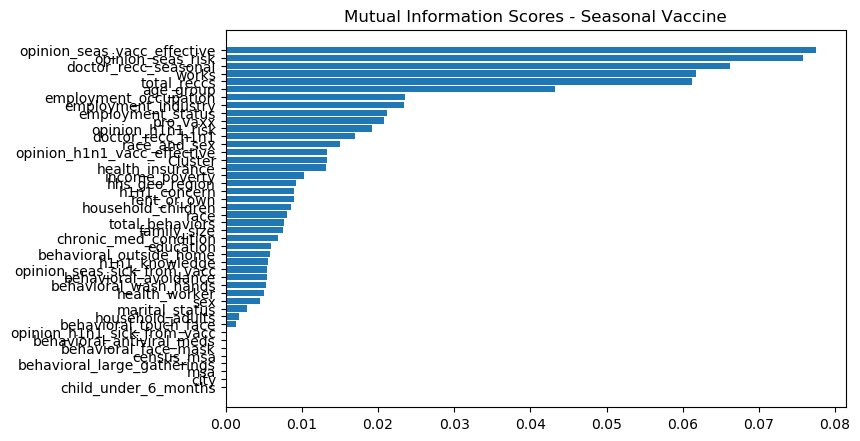

In [44]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores - Seasonal Vaccine")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores)

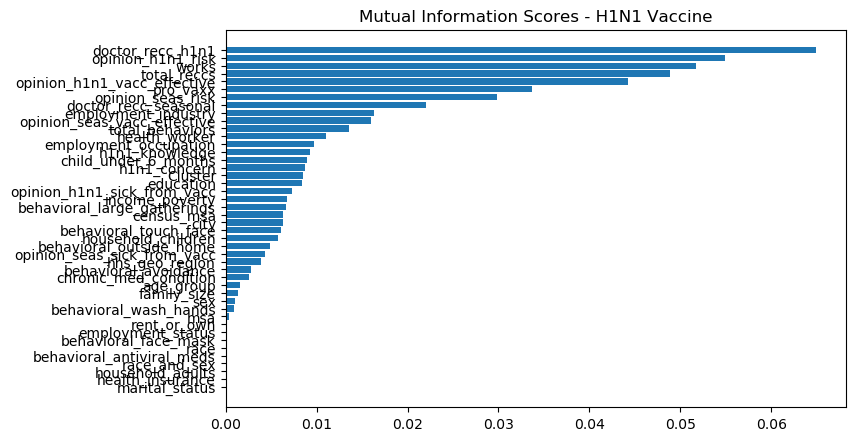

In [45]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores - H1N1 Vaccine")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores2)

In [50]:
X = train_new
#y = seasonal
y = h1n1

In [46]:
print(train_new.shape)
print(test_new.shape)

(26707, 44)
(26708, 44)


In [51]:
# define the base models
level0 = list()
level0.append(('lr', LogisticRegression(C = 1, penalty = 'l2', max_iter = 1000)))
level0.append(('rf', RandomForestClassifier(max_features = 0.25, min_samples_split = 6, n_estimators = 250)))
level0.append(('boost', GradientBoostingClassifier(learning_rate = 0.01, max_depth = 9, n_estimators = 100, subsample = 0.5)))
level0.append(('et', ExtraTreesClassifier(criterion = 'entropy', max_depth = 15)))
level0.append(('ada', AdaBoostClassifier(learning_rate = 1, n_estimators = 100)))
# define meta learner
level1 = LogisticRegression(C = 0.01, penalty = 'l2', max_iter = 1000)
# define the stacking ensemble
model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
# fit the model on all available data
model.fit(X, y)
# make predictions
yhat = model.predict_proba(test_new)

#GradientBoost Best: 0.822331 using {'learning_rate': 0.01, 'max_depth': 9, 'n_estimators': 100, 'subsample': 0.5} for h1n1 and seasonal
#AdaBoost Best: 0.782005 using {'learning_rate': 1.0, 'n_estimators': 500} for seasonal
#AdaBoost Best: 0.833440 using {'learning_rate': 1.0, 'n_estimators': 100} for h1n1
#RandomForest Best: 0.778535 using {'max_features': 0.25, 'min_samples_split': 6, 'n_estimators': 250} for seasonal, h1n1
#ExtraTreesClassifier Best: 0.776314 using {'criterion': 'gini', 'max_depth': 15} seasonal
#ExtraTreesClassifier Best: 0.833465 using {'entropy': 'gini', 'max_depth': 15} h1n1
#LogisticRegression Best: 0.774591 using {'C': 0.01, 'penalty': 'l2'} seasonal
#LogisticRegression Best: 0.832815 using {'C': 1, 'penalty': 'l2'} h1n1

In [49]:
y_pred_seasonal_final = pd.DataFrame(yhat, columns = ['first_class', 'second_class'])

In [52]:
y_pred_h1n1_final = pd.DataFrame(yhat, columns = ['first_class', 'second_class'])

In [53]:
response = pd.concat([ID, y_pred_h1n1_final['second_class'],y_pred_seasonal_final['second_class']], axis = 1)
response.columns = ['respondent_id','h1n1_vaccine', 'seasonal_vaccine']
response.to_csv('predictions.csv', index=False)

In [60]:
from xgboost import XGBClassifier
model_xgb = XGBClassifier()
model_xgb.fit(train_new, h1n1)

[15:25:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [61]:
xgb_train_pred = model_xgb.predict_proba(test_new)

In [ ]:
y_pred_xgb_seasonal = pd.DataFrame(xgb_train_pred, columns = ['first_class', 'second_class'])

In [62]:
y_pred_xgb_h1n1 = pd.DataFrame(xgb_train_pred, columns = ['first_class', 'second_class'])

In [67]:
import lightgbm as lgb
model_lgb = lgb.LGBMClassifier()
model_lgb.fit(train_new, h1n1)

LGBMClassifier()

In [68]:
lgb_train_pred = model_lgb.predict_proba(test_new)

In [66]:
y_pred_lgb_seasonal = pd.DataFrame(lgb_train_pred, columns = ['first_class', 'second_class'])

In [69]:
y_pred_lgb_h1n1 = pd.DataFrame(lgb_train_pred, columns = ['first_class', 'second_class'])

In [71]:
#create final model with 7 model ensemble
final_h1n1 = pd.DataFrame(0.7 * y_pred_h1n1_final['second_class'] + 0.15 * y_pred_xgb_h1n1['second_class'] + 
                          0.15 * y_pred_lgb_h1n1['second_class'], columns = ['h1n1_prediction'])

In [74]:
final_seasonal = pd.DataFrame(0.7*y_pred_seasonal_final['second_class'] + 0.15 * y_pred_xgb_seasonal['second_class'] + 
                             0.15 * y_pred_lgb_h1n1['second_class'], columns = ['seasonal_prediction'])

In [75]:
response = pd.concat([ID, final_h1n1['h1n1_prediction'],final_seasonal['seasonal_prediction']], axis = 1)
response.columns = ['respondent_id','h1n1_vaccine', 'seasonal_vaccine']
response.to_csv('predictions.csv', index=False)